In [1]:
from speclearn.tools.constants import *
from speclearn.plot.map import get_polar_loc
from speclearn.io.transform.bin_tools import make_bins
from speclearn.io.data.aoi import make_aoi_at_random
from speclearn.tools import get_rebin_path, to_radians, stereographic_projection
from speclearn.deep_learning.ml_tools import get_aoi_dataset
from speclearn.deep_learning.ml_tools import get_aoi_from_geojson

import seaborn as sns
from matplotlib.text import Text
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from speclearn.deep_learning.predict import get_coord, get_full_data
from speclearn.io.data.aoi import get_full_map_aoi_longitude
import pandas as pd
import numpy as np

In [2]:
aoi_full = {
    'name': 'loc_-180_180_-90_90',
    'lat_range': [-90, 90],
    'long_range': [-180, 180],
    'd_long': 0.05,
    'd_lat': 0.05,
}
latitude_range = f'{int(aoi_full['lat_range'][0])}_{int(aoi_full['lat_range'][1])}'
longitude_range = f'{int(aoi_full["long_range"][0])}_{int(aoi_full["long_range"][1])}'
suffix=''
full_file_name = f"{CACHE_PREDICT}/data_{longitude_range}_{latitude_range}.npy"
print(full_file_name)

/home/freya/Documents/Code/cache/predict_v2/data_-180_180_-90_90.npy


In [3]:
lat_mid_edges, lat_mid_centers = make_bins([-70,70], int(140/0.05))
long_edges, long_centers = make_bins([-180,180], int(360/0.05))
lat_south_edges, lat_south_centers = make_bins([-90,-60], int(30/0.05))
lat_north_edges, lat_north_centers = make_bins([60,90], int(30/0.05))

In [4]:
aoi_list = get_full_map_aoi_longitude(step_size=20)
#data = get_full_data(aoi_list, crs=False, norm=False, periods=[])
#coord = get_coord(aoi_list)
data = np.load('/home/freya/Documents/Code/cache/predict_v2/temp_full.npy')

cluster_2d = np.load('/home/freya/Documents/Code/cache/cluster_2d/3m3vgrkn_5_cluster_2d_70_lat_full.npy')
data[cluster_2d == -10] = -10
data[cluster_2d == float('NaN')] = float('NaN')
cluster_2d = None

data_mid = data[:,int(20/0.05):-int(20/0.05),:]
data_south = data[:,0:int(30/0.05),:]
data_north = data[:,-int(30/0.05):,:]

data_mid = np.rot90(data_mid)
data_north = np.rot90(data_north)
data_south = np.rot90(data_south)
data_north = np.flipud(data_north)
data_south = np.flipud(data_south)

In [5]:
df_mid = pd.DataFrame(data=data_mid[:,:,45], index=lat_mid_centers, columns=long_centers) # 45 is the 1489nm RFL
df_south = pd.DataFrame(data=data_south[:,:,45], index=lat_south_centers, columns=long_centers)
df_north = pd.DataFrame(data=data_north[:,:,45], index=lat_north_centers, columns=long_centers)

# Release memory
data_mid = None
data_south = None
data_north = None
data = None

/tmp/ipykernel_2027043/2936445483.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels([Text(0.0, 0, '0'),#


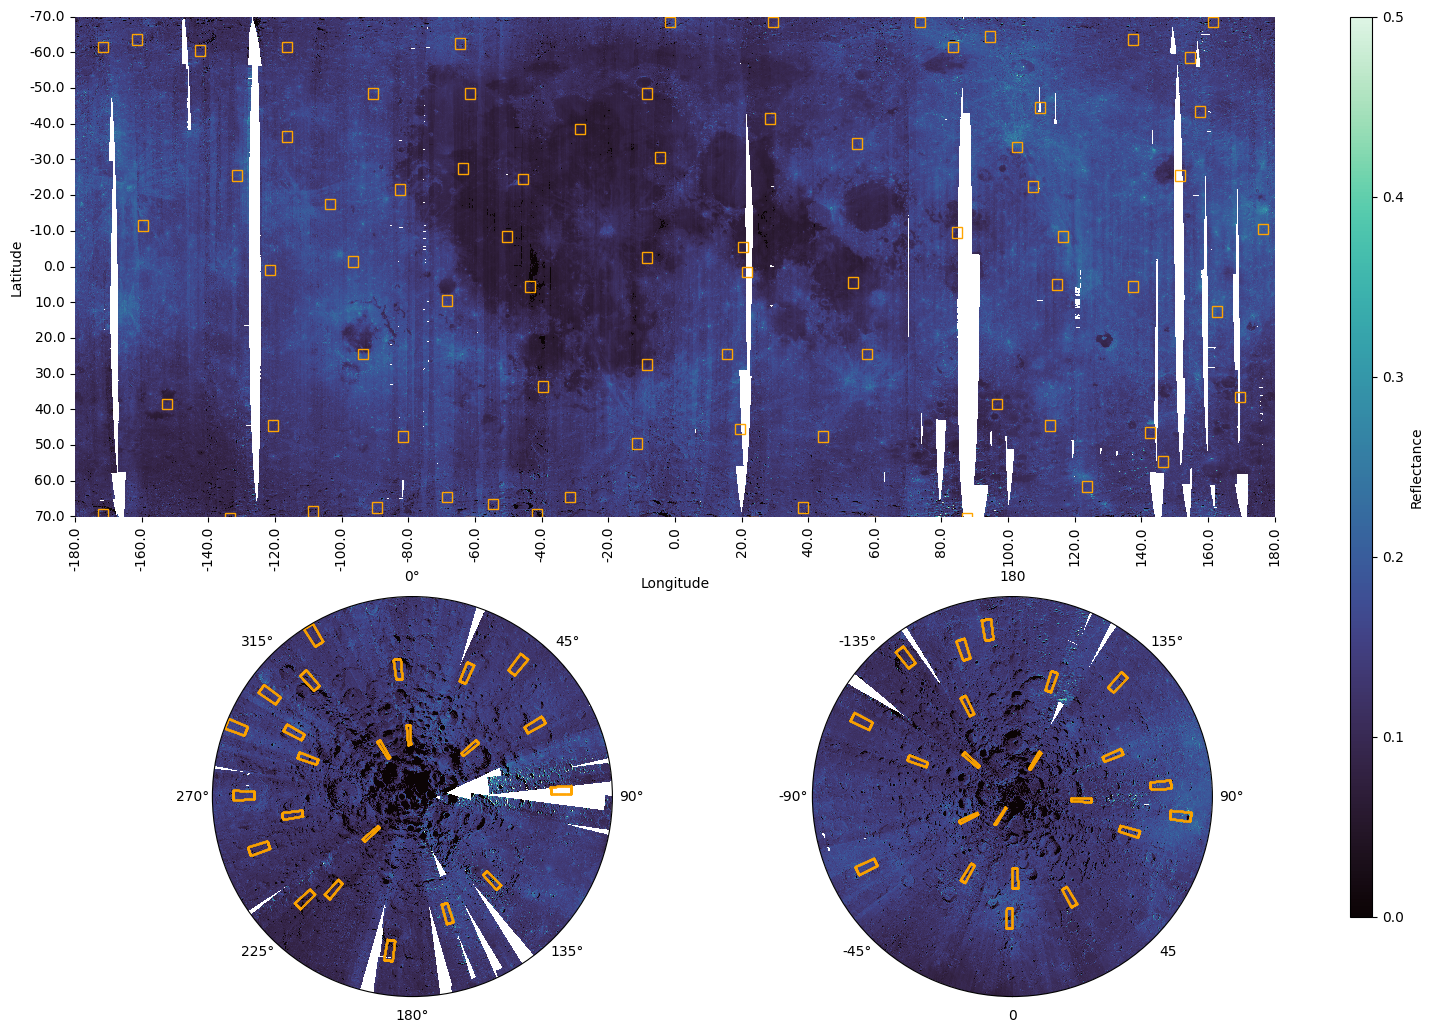

In [6]:
r_north, theta_north = get_polar_loc(df_north, area='north')
r_south, theta_south = get_polar_loc(df_south, area='south')

_min = 0.0
_max = 0.5#np.nanmax([df_mid.values.max(), df_south.values.max(), df_north.values.max()])

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_axes([0.0, 0.48, 0.8, 0.5])
ax2 = fig.add_axes([0.0, 0.0, 0.45, 0.4], polar=True)
ax3 = fig.add_axes([0.4, 0.0, 0.45, 0.4], polar=True)

# Create the shared colorbar axis AFTER creating the subplots
cbar_ax = fig.add_axes([0.85, 0.08, 0.015, 0.9])  # left, bottom, width, height
fig.subplots_adjust(right=0.8)

# set nan values to 0 for plotting
#df_mid = df_mid.fillna(0)
#df_south = df_south.fillna(0)
#df_north = df_north.fillna(0)

# Heatmap with shared colorbar
im = sns.heatmap(df_mid, cmap='mako', ax=ax1, vmin=_min, vmax=_max, cbar=True, cbar_ax=cbar_ax)

ax1.set_xticks(np.linspace(0.5, df_mid.shape[1] - 1.0, 19))
ax1.set_xticklabels(f'{c:.1f}' for c in np.linspace(-180, 180, 19, dtype=int))
ax1.set_yticks(np.linspace(0.5, df_mid.shape[0] - 1.0, 15))
ax1.set_yticklabels(f'{c:.1f}' for c in np.linspace(-70, 70, 15, dtype=int))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Polar plots with shared colorbar and specified colormap
dr = np.fabs((r_south[0] - r_south[1]) / 2)
ax2.set_rlim(np.min(r_south) - dr, np.max(r_south) + dr)
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2.0)
ax2.grid(False)
im2 = ax2.pcolormesh(theta_south, r_south, df_south, vmin=_min, vmax=_max, cmap='mako')  # Set cmap here
ax2.set_yticklabels([])

dr = np.fabs((r_north[0] - r_north[1]) / 2)
ax3.set_rlim(np.min(r_north) - dr, np.max(r_north) + dr)
ax3.set_theta_direction(1)
ax3.set_theta_offset(np.pi / 2.0)
ax3.set_theta_zero_location("S")

ax3.set_xticklabels([Text(0.0, 0, '0'),#
                     Text(0.7853981633974483, 0, '45'),
                     Text(1.5707963267948966, 0, '90°'), #
                     Text(2.356194490192345, 0, '135°'), #
                     Text(3.141592653589793, 0, '180'),
                     Text(3.9269908169872414, 0, '-135°'),
                     Text(4.71238898038469, 0, '-90°'),
                     Text(5.497787143782138, 0, '-45°')])
ax3.grid(False)
im3 = ax3.pcolormesh(np.array(theta_north), np.array(r_north), df_north, vmin=_min, vmax=_max, cmap='mako')  # Set cmap here
ax3.set_yticklabels([])

# Get the ScalarMappable from the heatmap
sm = im.get_children()[0]

# Explicitly use cbar_ax for all plots
fig.colorbar(sm, cax=cbar_ax, label='Reflectance')  # Heatmap

#aois = get_aoi_dataset()

aois = get_aoi_from_geojson('/home/freya/Documents/Code/cache/geojson/aoi_minerals_full.geojson')

for _aoi in aois:
    min_arg = np.nanargmin(np.fabs(-lat_mid_edges-_aoi['lat_range'][0]))
    if (_aoi['lat_range'][0]) > 60 :
        x = to_radians(np.linspace(_aoi['lat_range'][0], _aoi['lat_range'][0], 100))
        y = to_radians(np.linspace(_aoi['long_range'][0], _aoi['long_range'][1], 100))
        r, theta = stereographic_projection(y, x)
        ax3.scatter(theta, r, c='orange', ls='-', s=0.05)

        x = to_radians(np.linspace(_aoi['lat_range'][0], _aoi['lat_range'][1], 100))
        y = to_radians(np.linspace(_aoi['long_range'][0], _aoi['long_range'][0], 100))
        r, theta = stereographic_projection(y, x)
        ax3.scatter(theta, r, c='orange', ls='-',  s=0.05)

        x = to_radians(np.linspace(_aoi['lat_range'][1], _aoi['lat_range'][1], 100))
        y = to_radians(np.linspace(_aoi['long_range'][0], _aoi['long_range'][1], 100))
        r, theta = stereographic_projection(y, x)
        ax3.scatter(theta, r, c='orange', ls='-', s=0.05)

        x = to_radians(np.linspace(_aoi['lat_range'][0], _aoi['lat_range'][1], 100))
        y = to_radians(np.linspace(_aoi['long_range'][1], _aoi['long_range'][1], 100))
        r, theta = stereographic_projection(y, x)
        ax3.scatter(theta, r, c='orange', ls='-', s=0.05)


    if (_aoi['lat_range'][0]) < -60 :
        x = to_radians(np.linspace(-_aoi['lat_range'][0], -_aoi['lat_range'][0], 100))
        y = to_radians(np.linspace(_aoi['long_range'][0], _aoi['long_range'][1], 100))
        r, theta = stereographic_projection(y, x)
        ax2.scatter(theta, r, c='orange', ls='-', s=0.05)

        x = to_radians(np.linspace(-_aoi['lat_range'][1], -_aoi['lat_range'][0], 100))
        y = to_radians(np.linspace(_aoi['long_range'][0], _aoi['long_range'][0], 100))
        r, theta = stereographic_projection(y, x)
        ax2.scatter(theta, r, c='orange', ls='-',  s=0.05)

        x = to_radians(np.linspace(-_aoi['lat_range'][1], -_aoi['lat_range'][1], 100))
        y = to_radians(np.linspace(_aoi['long_range'][0], _aoi['long_range'][1], 100))
        r, theta = stereographic_projection(y, x)
        ax2.scatter(theta, r, c='orange', ls='-',  s=0.05)

        x = to_radians(np.linspace(-_aoi['lat_range'][1], -_aoi['lat_range'][0], 100))
        y = to_radians(np.linspace(_aoi['long_range'][1], _aoi['long_range'][1], 100))
        r, theta = stereographic_projection(y, x)
        ax2.scatter(theta, r, c='orange', ls='-',  s=0.05)
    if np.fabs(_aoi['lat_range'][0]) < 72:
        ax1.add_patch(
            patches.Rectangle(
                (np.nanargmin(np.fabs(long_edges-_aoi['long_range'][0])), min_arg),
                6*10,
                6*10,
                edgecolor='orange',
                fill=False,
                lw=1
            ))

plt.savefig('../figures/data/training_data.png', dpi=300, bbox_inches='tight')
plt.show()